In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

# GP on 2D data
Dataset "visium" from https://spatialdata.scverse.org/en/latest/tutorials/notebooks/datasets/README.html


In [38]:
import numpy as np
import anndata as ad
import scanpy as sc
import torch
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap.umap_ as umap # umap-learn
import spatialdata as sd
import pyro
import seaborn as sns

import cellij

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

# random seed to use throughout the notebook
SEED = 123

torch.manual_seed(SEED)
np.random.seed(SEED)


In [3]:
visium_sdata = sd.read_zarr("/Users/tim.treis/Documents/GitHub/spatialdata-notebooks/notebooks/examples/visium.zarr")

/Users/tim.treis/anaconda3/envs/spatialdata/envs/cellij/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
sdata = visium_sdata.filter_by_coordinate_system("ST8059048")

In [5]:
obs = sdata.table.obs
obs = obs[["array_row", "array_col", "spot_id"]]
# obs.index = [f"spot_{i:04}" for i in obs.spot_id.values.tolist()]
del obs["spot_id"]
obs.columns = ["y", "x"]
obs.head(3)

,y,x
AAACAAGTATCTCCCA-1,50,102
AAACACCAATAACTGC-1,59,19
AAACAGAGCGACTCCT-1,14,94


In [6]:
dense_data = sdata.table.X.toarray().astype(float)
data = pd.DataFrame(
    dense_data,
    columns=sdata.table.var.index,
    index=sdata.table.obs.index,
)
data.head(3)

,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
AAACAAGTATCTCCCA-1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [27]:
model = cellij.core.models.SimpleGP(
    n_factors=10
)

model.add_data(name="visium", data=data)
model.add_covariate(obs)
model.fit(
    likelihoods="Normal",
    epochs=2,
    verbose_epochs=1,
    learning_rate=0.01,
)


(2987, 31053)
Training Model...
- Epoch      0/2 | Train Loss:           0.00 	
- Epoch      1/2 | Train Loss:           0.01 	| Decrease: -1266.67%	| Time:  35.94s
- Epoch      2/2 | Train Loss:           0.26 	| Decrease: -5031.71%	| Time:  37.14s
Training finished.
- Final loss: 0.26
- Training took 125.12s


In [22]:
model.data.shape

(2987, 31053)

<Axes: >

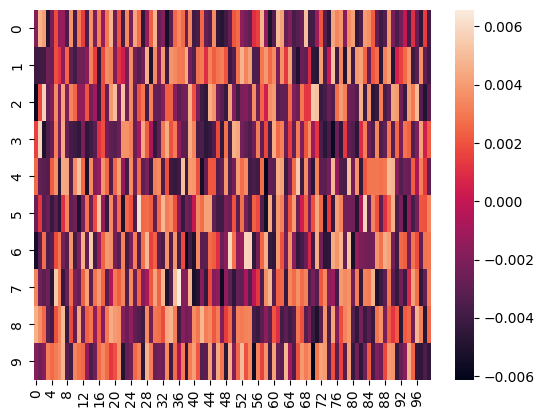

In [41]:
a = pyro.get_param_store()["FactorModel._guide.gp$$$variational_strategy._variational_distribution.variational_mean"]
sns.heatmap(a.detach().numpy())

0.0039


NameError: name 'mdata' is not defined

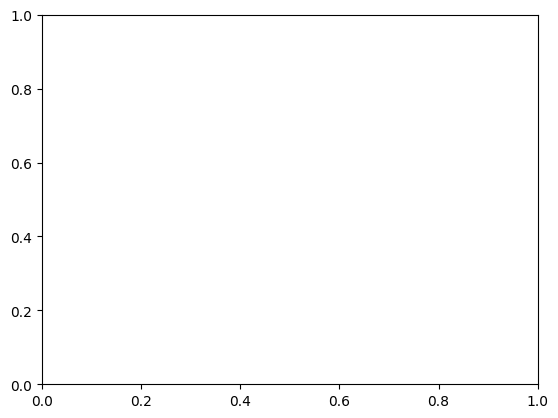

In [28]:
factor_means = []
with torch.no_grad():
    dist = model.gp(model.covariate)
    samples = dist(torch.Size([100])).cpu()
    mean = samples.mean(dim=0)
    mean = torch.transpose(mean, -1, -2)
    factor_means.append(torch.transpose(mean, -1, -2))

factor_means = torch.stack(factor_means, dim=0)

print(round(float(factor_means.squeeze()[0][0]), 4))

for i in range(10):
    try:
        plt.scatter(model.covariate.cpu().detach().numpy(), factor_means.squeeze()[i], )
    except:
        pass
    
# umap_obj = umap.UMAP()
# result = umap_obj.fit_transform(factor_means.squeeze().T)

pca = PCA(n_components=2)
result = pca.fit_transform(factor_means.squeeze().T)

result = pd.DataFrame(result)
result["time"] = mdata.obs["division_scaled"].values
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(8, 3.5))
s = axs.scatter(result[0], result[1], c = result["time"])
fig.colorbar(s, ax=axs)